# Deep Matching and Validation Network (with Keras-Theano)

This notebook demonstrates how to use the Keras nenural network framework (with the Theano backend) to produce splicing localization and detection results.

Before you run the notebook below, make sure that you correctly set up your **Keras enviroment**, and that standard libraries **NumPy**, **IPython**, and **cv2**(v2.4.9) are available.

## Step 1. Load all required libs


In [2]:
%matplotlib inline
import os
import cv2
import sys
import numpy as np 
dmvn_root = os.getcwd()
data_root = os.path.join( dmvn_root, 'data', 'small' ) 
dmvn_lib = os.path.join( dmvn_root, 'lib', 'dmvn' )
sys.path.insert( 0, dmvn_lib )
from utils import visualize_ipynb, preprocess_images
from core import create_DMVN_model
from itertools import combinations
from matplotlib import pyplot

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


## Step 2. Prepare testing samples

### 2.1 Load all testing images and pair them to samples

We will load 40 small 256x256 images (resized from original data in CASIA TIDEv2). Since the constrained image splicing problem requires a pair of images as input, we need to randomly pair these testing images to DMVN samples. As a result we have in total 40 * 39 / 2 = 780 DMVN samples

In [3]:
all_testing_image_files = filter( lambda f : f.endswith('.jpg'), [ os.path.join( data_root, f ) for f in os.listdir( data_root ) ] )
all_dmvn_samples = [ pair for pair in combinations( all_testing_image_files, 2 ) ]
print "INFO: successfully paired", len( all_dmvn_samples ), "splicing samples"

INFO: successfully paired 780 splicing samples


### 2.2 Infer the ground truth labels for samples 

To obtain the ground truth label of splicing samples, we need to check file names in a sample. According to the naming rule used by the CASIA TIDEv2 dataset (http://forensics.idealtest.org/casiav2/), 

    - the name of a tempered image starts with *Tp*
    - the name of an authentic image starts with *Au* 
    - the name of a tempered image contains authentic image index
    
For example, *Tp_D_NNN_M_N_**art00052**_nat00013_11848.jpg* is a tempered image, and it contains content from authentic images *Au_**art_00052**.jpg* and *Au_**nat_00013**.jpg*. In this way, we can infer the ground truth label for a randomly paired image splicing sample as shown in **infer_sample_label**. 


In [4]:
def infer_sample_label( probe_file, donor_file ) :
    '''Infer a testing sample's label from CASIA TIDEv2 naming rules
    '''
    probe_fields = os.path.basename( probe_file ).rsplit('.')[0].split("_")
    donor_fields = os.path.basename( donor_file ).rsplit('.')[0].split("_")
    probe_type = 'Au' if ( len( probe_fields ) == 3 ) else 'Tp'
    donor_type = 'Au' if ( len( donor_fields ) == 3 ) else 'Tp'
    if ( probe_type == donor_type ) :
        return 0
    else :
        if ( len( probe_fields ) < len( donor_fields ) ) :
            Tp_fields, Au_fields = donor_fields, probe_fields
        else :
            Tp_fields, Au_fields = probe_fields, donor_fields
        Tp_index = "_".join( [ Tp_fields[-2], Tp_fields[-3] ] )
        Au_index = "".join( Au_fields[-2:] )
        return ( Au_index in Tp_index )

all_dmvn_labels = np.array( [ infer_sample_label( probe_file, donor_file ) for probe_file, donor_file in all_dmvn_samples ] )
print "INFO: in all samples, found", np.sum( all_dmvn_labels ), "positive samples"

INFO: in all samples, found 10 positive samples


## Step 3. Testing DMVN on random samples 

### 3.1 Load the pretrained DMVN model
This will take several seconds to construct the model.

In [5]:
dmvn_end_to_end = create_DMVN_model()

////////////////////////////////////////////////////////////////////////////////////////////////////
INFO: create CNN Feature Extractor
////////////////////////////////////////////////////////////////////////////////////////////////////
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 256, 256)   0                                            
____________________________________________________________________________________________________
vgg16_cnn_featex-block1_conv1 (C (None, 64, 256, 256)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
vgg16_cnn_featex-block1_conv2 (C (None, 64, 256, 256)  36928       vgg16_cnn_featex-block1_conv1[0][
________________________________________________________

### 3.2 Define auxillary function to fetch data and make DMVN prediction

In [6]:
def fetch_a_random_sample( all_samples, all_labels, constraint = None ) :
    if ( constraint is None ) :
        valid_indices = range( len( all_labels ) )
    else :
        target_label = 1 if ( constraint.lower() == 'positive' ) else 0
        valid_indices = np.nonzero( all_labels == target_label )[0].tolist()
    ridx = np.random.choice( valid_indices, 1 )[0]
    print "INFO: use sample of idx =", ridx
    return all_samples[ ridx ], all_labels[ ridx ]

def visualization_wrapper( Xd3d, Xp3d, pred_masks, pred_probs, gt_label ) :
    pred_label = pred_probs.ravel()[1] > .5
    if ( pred_label ) or ( pred_label != gt_label ):
        # display this splicing sample, and localized masks if prediction is positive or incorrect
        vis_input, vis_mask, vis_overlay = visualize_ipynb( Xd3d, Xp3d, pred_masks, pred_probs )
        pyplot.figure( figsize = ( 100, 20 ) )
        pyplot.subplot(3,1,1)
        pyplot.imshow( vis_input )
        pyplot.title( 'input splicing sample' )
        pyplot.axis('off')
        pyplot.subplot(3,1,2)
        pyplot.imshow( vis_mask )
        pyplot.title( 'predicted splicing masks' )
        pyplot.axis('off')
        pyplot.subplot(3,1,3)
        pyplot.imshow( vis_overlay )
        pyplot.title( 'highlighted splicing regions on inputs' )
        pyplot.axis('off')
        pyplot.show()
    else :
        print "INFO: only visualize input sample"
        vis_input, vis_mask, vis_overlay = visualize_ipynb( Xd3d, Xp3d, pred_masks, pred_probs )
        pyplot.figure( figsize = ( 100, 20 ) )
        pyplot.imshow( vis_input )
        pyplot.title( 'input splicing sample' )
        pyplot.axis('off')
    return

def dmvn_prediction( probe_file, donor_file, gt_label ) :
    # prepare DMVN input 
    Xp, Xd = preprocess_images( [ probe_file, donor_file ] )
    X = { 'probe' : Xp, 'world' : Xd }
    print "INFO: probe_tensor.shape =", Xp.shape, "donor_tesnor.shape =", Xd.shape
    # make DMVN prediction
    pred_masks, pred_probs = dmvn_end_to_end.predict( X )
    donor_mask, probe_mask = pred_masks[0]
    proba = pred_probs.ravel()[1]
    print "INFO: pred_masks.shape =", pred_masks.shape, "splicing proba =", proba
    pred_label = proba > .5
    if ( pred_label == gt_label ) :
        print "INFO: correct prediction"
    else :
        print "WARNING: INCORRECT prediction"
    print "INFO: true_label =", gt_label, "pred_label =", int( pred_label )
    visualization_wrapper( Xd[0], Xp[0], pred_masks[0], pred_probs[0], gt_label )
    donor_tensor, probe_tensor = Xd[0], Xp[0]
    return ( probe_tensor, probe_mask ), ( donor_tensor, donor_mask ), proba


### 3.3 DMVN prediction on a single sample


INFO: use sample of idx = 293
INFO: load one random sample ('Tp_D_NRN_S_N_art20006_art20005_01812-0.jpg', 'Tp_D_CRN_M_B_sec00085_arc00065_11450.jpg') of label 0
INFO: probe_tensor.shape = (1, 3, 256, 256) donor_tesnor.shape = (1, 3, 256, 256)
INFO: pred_masks.shape = (1, 2, 256, 256) splicing proba = 0.0145211
INFO: correct prediction
INFO: true_label = 0 pred_label = 0
INFO: only visualize input sample


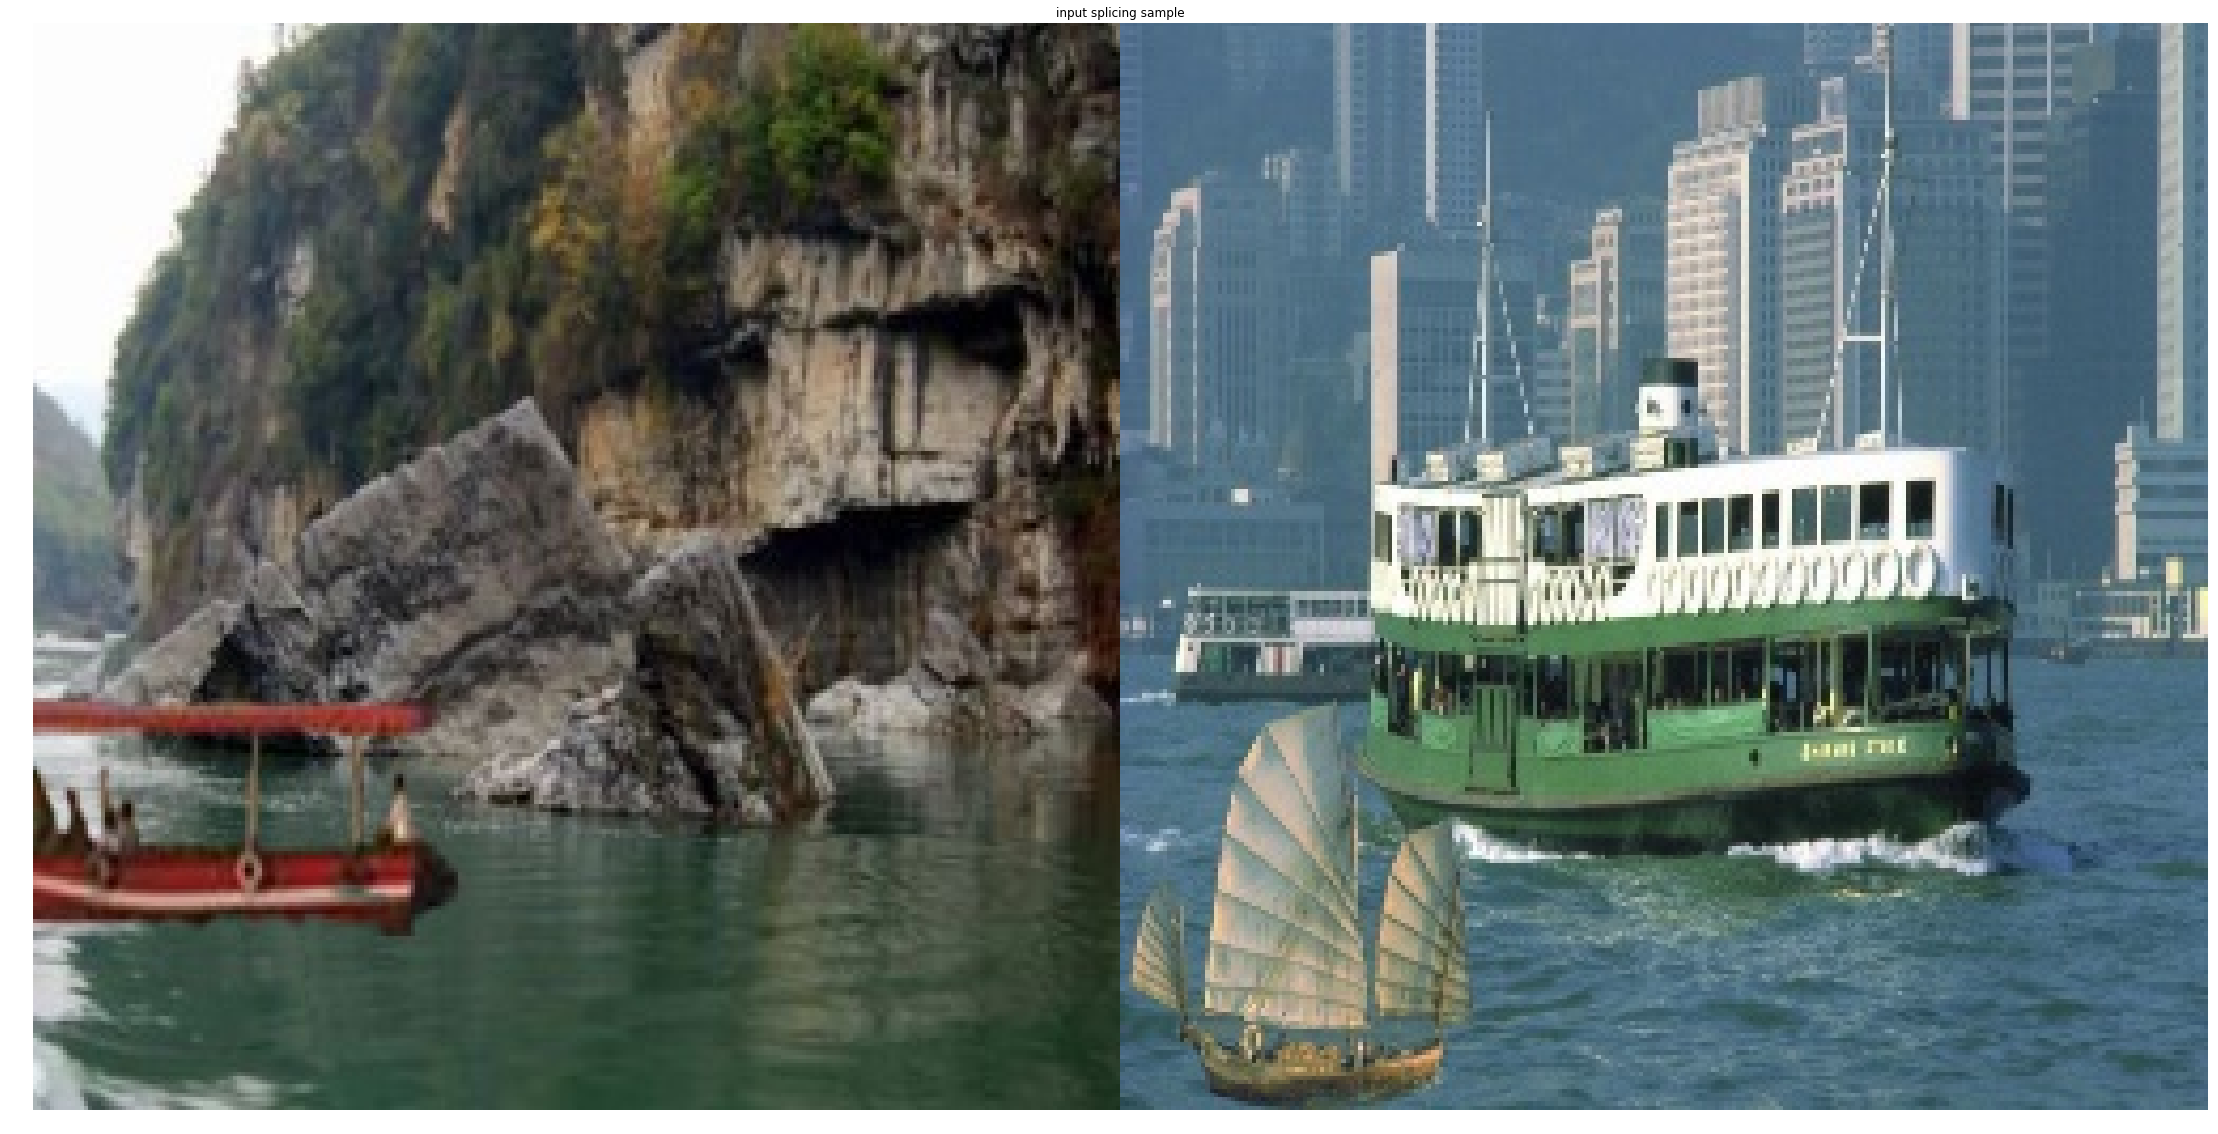

In [7]:
# load a random negative sample
a_random_sample, sample_label = fetch_a_random_sample( all_dmvn_samples, all_dmvn_labels, constraint = 'negative' )
probe_file, donor_file = a_random_sample 
print "INFO: load one random sample", ( os.path.basename( probe_file ), os.path.basename( donor_file ) ), "of label", sample_label
_ = dmvn_prediction( probe_file, donor_file, sample_label )

INFO: use sample of idx = 92
INFO: load one random sample ('Au_sec_00085.jpg', 'Tp_D_CRN_M_B_sec00085_arc00065_11450.jpg') of label 1
INFO: probe_tensor.shape = (1, 3, 256, 256) donor_tesnor.shape = (1, 3, 256, 256)
INFO: pred_masks.shape = (1, 2, 256, 256) splicing proba = 1.0
INFO: correct prediction
INFO: true_label = 1 pred_label = 1


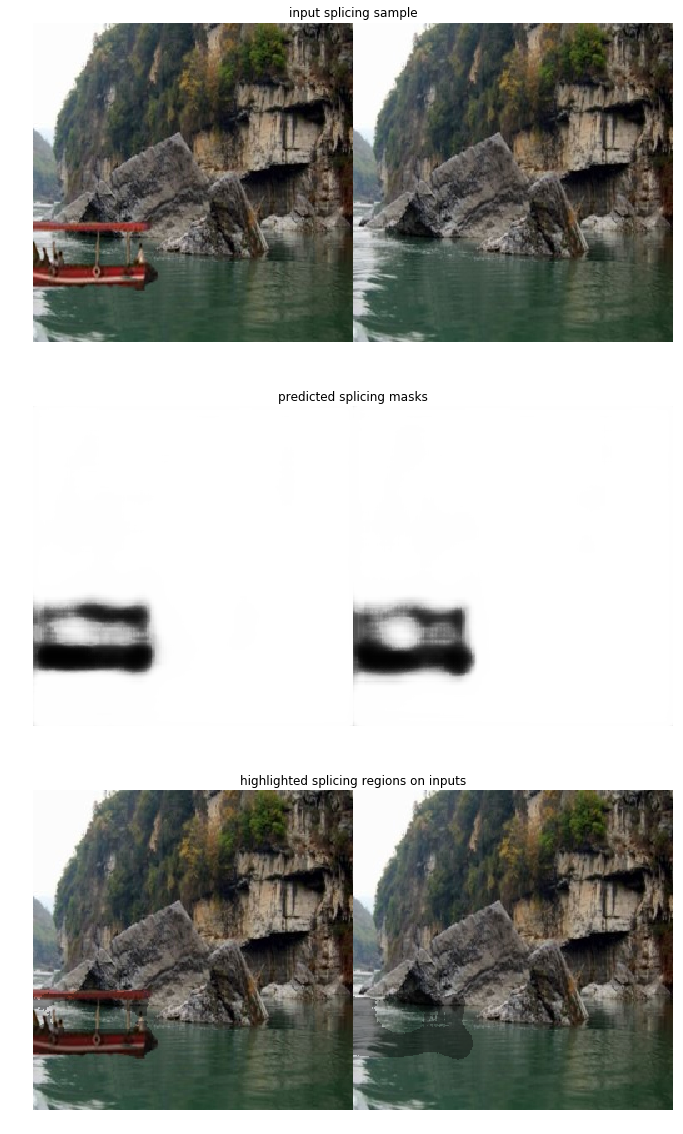

In [8]:
# load a random positive sample
a_random_sample, sample_label = fetch_a_random_sample( all_dmvn_samples, all_dmvn_labels, constraint = 'positive' )
probe_file, donor_file = a_random_sample 
print "INFO: load one random sample", ( os.path.basename( probe_file ), os.path.basename( donor_file ) ), "of label", sample_label
_ = dmvn_prediction( probe_file, donor_file, sample_label )